In [11]:
from pandas import DataFrame
import glob
import os
import json
import re

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import the wordcloud library
from wordcloud import WordCloud
from IPython.display import Image 

In [2]:

def get_headlines_by_year(year):

    path = 'data/guardian/' + year

    headlines = []

    for filename in glob.glob(os.path.join(path, '*.json')):
        if '-b.json' in filename:
            continue

        with open(filename, 'r') as f: 
            for hd in json.load(f):
                headlines.append(hd)

    df = DataFrame (headlines, columns=['headlines'])


    # Remove punctuation
    df['headlines_processed'] = df['headlines'].map(lambda x: re.sub('[,\.!?]', '', x))
    # Convert the titles to lowercase
    df['headlines_processed'] = df['headlines_processed'].map(lambda x: x.lower())
    # Print out the first rows of papers
    df['headlines_processed'].head()
    return df

In [15]:
def generate_wc(df, year):
    # Join the different processed titles together.
    long_string = ','.join(list(df['headlines_processed'].values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=50000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    wordcloud.to_image()
    wordcloud.to_file('images/' + year + '.png')
    
    pil_img = Image(filename='images/' + year + '.png')
    display(pil_img)

In [19]:
def generate_w_fq(df):
    sns.set_style('whitegrid')
    %matplotlib inline
    # Helper function
    def plot_20_most_common_words(count_data, count_vectorizer):
        import matplotlib.pyplot as plt
        words = count_vectorizer.get_feature_names()
        total_counts = np.zeros(len(words))
        for t in count_data:
            total_counts+=t.toarray()[0]

        count_dict = (zip(words, total_counts))
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
        words = [w[0] for w in count_dict]
        counts = [w[1] for w in count_dict]
        x_pos = np.arange(len(words)) 

        plt.figure(2, figsize=(5, 5/1.6180))
        plt.subplot(title='20 most common words')
        sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
        sns.barplot(x_pos, counts, palette='husl')
        plt.xticks(x_pos, words, rotation=90) 
        plt.xlabel('words')
        plt.ylabel('counts')
        plt.show()
    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english')
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(df['headlines_processed'])
    # Visualise the 10 most common words
    plot_20_most_common_words(count_data, count_vectorizer)

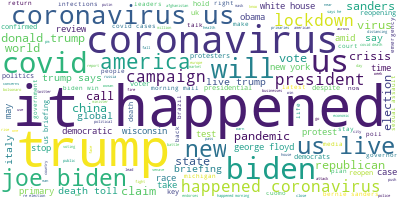

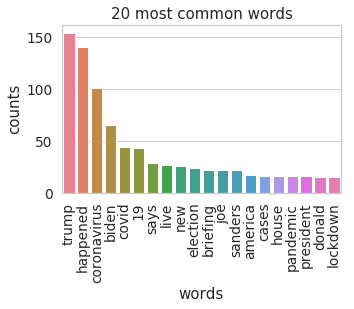

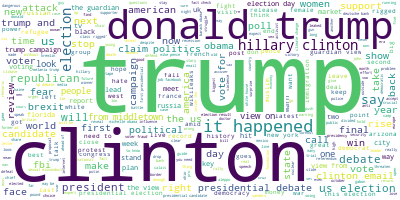

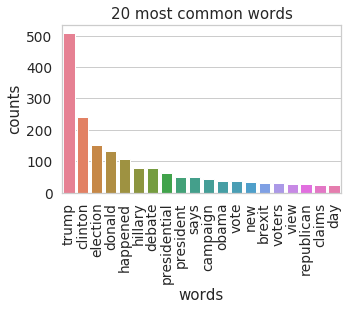

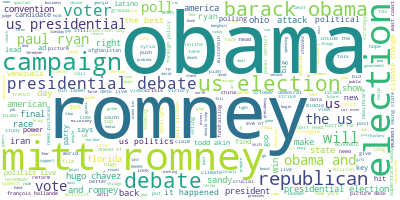

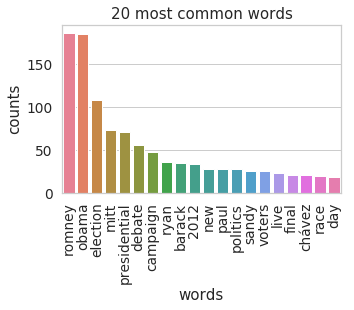

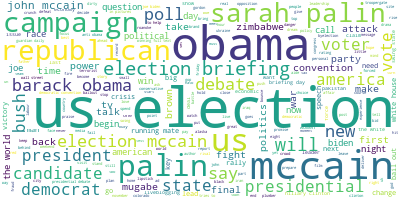

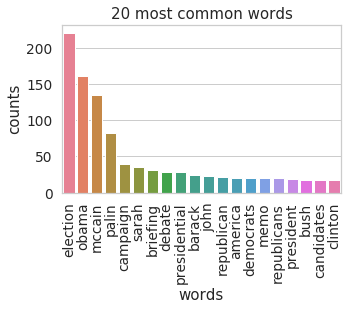

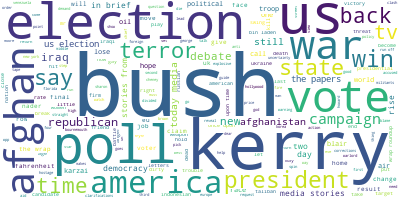

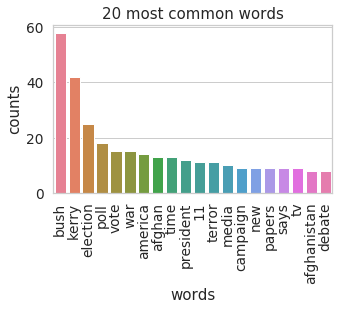

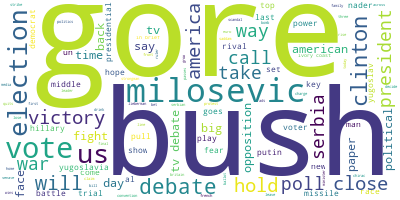

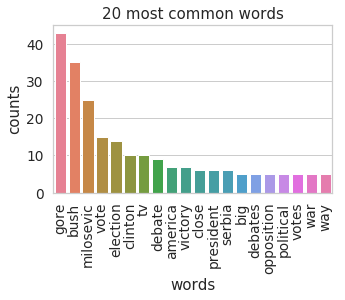

In [20]:
for y in ['2020', '2016', '2012', '2008', '2004', '2000']:

    df = get_headlines_by_year(y)
    generate_wc(df, y)

    generate_w_fq(df)

### Prepare text for LDA Analysis

In [52]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
trump election donald clinton says happened new campaign view time

Topic #1:
trump president happened clinton says vote brexit claims like sexual

Topic #2:
clinton trump happened debate election hillary presidential 2016 vote donald

Topic #3:
trump clinton hillary donald debate presidential election voters campaign obama

Topic #4:
trump election clinton presidential vote donald view state time debate


In [58]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')


/home/rmh/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: write() argument must be str, not bytes